## Data Generator

In [1]:
import sys
print(sys.version)

2.7.13 |Continuum Analytics, Inc.| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
from utils.parser import parse_inputs    # Data handler for LISA dataset

training_instances = parse_inputs('/home/dat/Documents/yolov2/dataset/lisa_extension/training.txt')
print("Train: {} samples\nNumber of classes:".format(len(training_instances)))

# Display few instances
for i in training_instances.keys()[0:5]:
    print(str(i).split('/')[-1], training_instances[i])

Train: 3305 samples
Number of classes:
('speedLimit25_1405359176.avi_image1.png', [[1063.5, 358.0, 51.0, 66.0, 'speedLimit25']])
('keepRight_1405362361.avi_image1.png', [[529.5, 522.5, 19.0, 27.0, 'keepRight']])
('signalAhead_1405034694.avi_image3.png', [[215.0, 477.5, 46.0, 47.0, 'signalAhead'], [821.5, 455.0, 63.0, 64.0, 'signalAhead']])
('stop_1398984376.avi_image7.png', [[936.5, 428.0, 51.0, 58.0, 'stop']])
('speedLimit40_1405111870.avi_image0.png', [[964.0, 478.5, 24.0, 31.0, 'speedLimit40']])


In [4]:
from utils.data_generator import flow_from_list
from cfg import *

data_gen   = flow_from_list(training_instances, batch_size=32)

['doNotEnter' 'curveRight' 'speedLimit35' 'pedestrianCrossing' 'stop'
 'stopAhead' 'signalAhead' 'intersectionLaneControl'
 'bicyclesMayUseFullLane' 'speedLimit25' 'yieldToPedestrian' 'noParking'
 'speedLimit15' 'speedBumpsAhead' 'speedLimit30' 'curveLeft'
 'noLeftAndUTurn' 'noUTurn' 'keepRight' 'leftAndUTurnControl' 'merge'
 'speedLimit40' 'speedLimit45' 'addedLane' 'speedLimit50' 'school'
 'intersection' 'laneEnds' 'noRightTurn' 'yieldAhead' 'speedLimit60']


In [8]:
images, labels  = data_gen.next()

print("Images shape {}".format(images[0].shape))
print("List of images : {}".format(np.shape(images)))
print("List of labels : {}\n".format(np.shape(labels)))

Images shape (608, 608, 3)
List of images : (32, 608, 608, 3)
List of labels : (32, 19, 19, 180)



0.897265625, 0.466145833333, 0.03046875, 0.059375


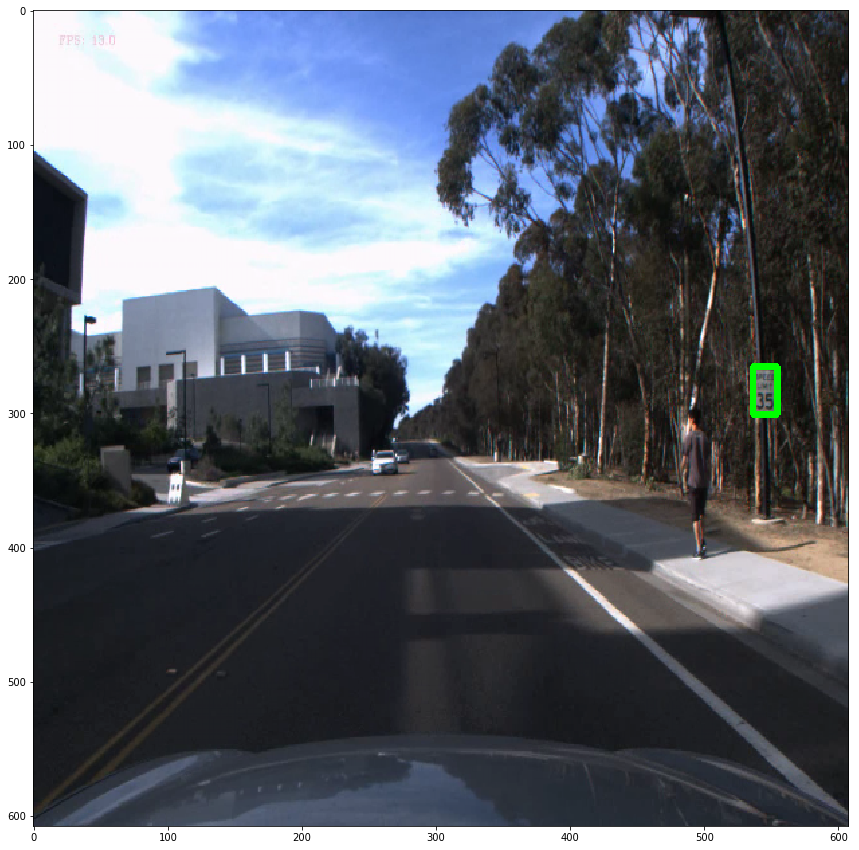

In [9]:
from utils.draw_boxes import draw, DrawingBox
from utils.box import Box
import matplotlib.pyplot as plt
%matplotlib inline
import cv2


i = np.random.randint(0, len(images))
img = images[i]
label = labels[i]
height, width, _ = images[i].shape

def draw_box(img, bboxes):
    for bbox in bboxes:
        img = cv2.rectangle(img, bbox[0], bbox[1], color=[0, 1.0, 0], thickness=3)
    return img

def get_gt(label):
        
    tmp = label[label > 0.]
    bboxes = []
    if len(tmp[0:4]) == 0 :
        bbox = Box(0,0,0,0)
    else:
        for i in range(0, len(tmp), (6*N_ANCHORS)):
            xc, yc, w ,h = tmp[tmp > 0][i:i + 4]
            bbox = Box(xc, yc, w ,h)
            print(bbox)
            bbox.to_abs_size((width, height))
            opencv_box = bbox.to_opencv_format()[0]
            bboxes.append(opencv_box)
    return bboxes

bboxes = get_gt(label)
plt.figure(figsize=(15, 15))
plt.imshow(draw_box(img, bboxes))

('Image size:', (608, 608, 3))
(0, 0)
0.312890625, 0.390104166667, 0.08359375, 0.105208333333
(0, 1)
0.68671875, 0.5140625, 0.025, 0.0427083333333
(0, 2)
0.897265625, 0.466145833333, 0.03046875, 0.059375
(0, 3)
0.697265625, 0.484895833333, 0.03671875, 0.0489583333333
(0, 4)
0.323046875, 0.390104166667, 0.07265625, 0.0989583333333
0.769921875, 0.426041666667, 0.05546875, 0.0708333333333
(0, 5)
0.36875, 0.5, 0.0265625, 0.0354166666667
0.593359375, 0.4859375, 0.02734375, 0.034375
(1, 0)
0.896484375, 0.491666666667, 0.02578125, 0.0354166666667
(1, 1)
0.75390625, 0.448958333333, 0.046875, 0.08125
(1, 2)
0.74609375, 0.466145833333, 0.0734375, 0.113541666667
(1, 3)
0.840234375, 0.4046875, 0.03046875, 0.059375
(1, 4)
0.748828125, 0.494270833333, 0.03671875, 0.059375
(1, 5)
0.6828125, 0.433854166667, 0.0390625, 0.0572916666667
(2, 0)
0.4359375, 0.499479166667, 0.028125, 0.0447916666667
0.843359375, 0.501041666667, 0.02734375, 0.0479166666667
(2, 1)
0.310546875, 0.473958333333, 0.02890625, 0.037

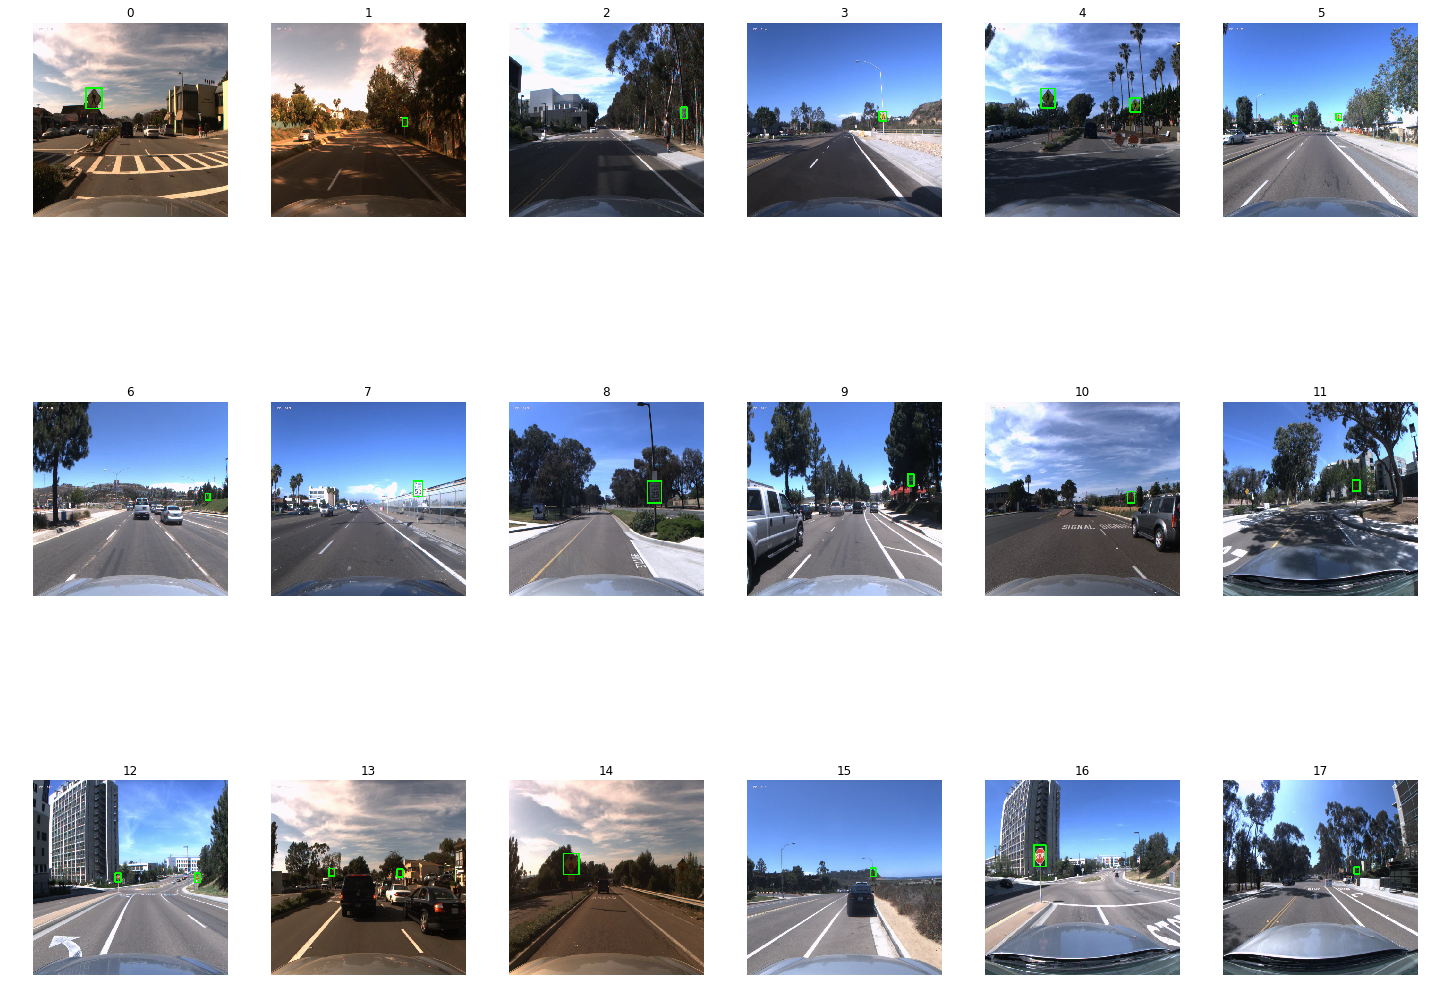

In [10]:
from utils.box import Box
import matplotlib.pyplot as plt
%matplotlib inline

row, col = 3, 6
fg, a    = plt.subplots(row, col, figsize =(20, 18))
fg.tight_layout()
height, width, _ = images[0].shape
print("Image size:", images[0].shape)
i        = 0
for r in range(row):
    for c in range(col):
        print(r, c)
        bboxes = get_gt(labels[i])
        a[r, c].axis('off')
        plt.tight_layout()
        a[r, c].imshow(draw_box(images[i], bboxes))
        a[r, c].set_title(str(i))
        i +=1